# Geometrics Data IO
This notebook demonstrates how to read in and manipulate geometrics data files. These files are ascii formatted text files, with an extension of `.stn`
> **Note**:
> These files have also been compressed in this repository to save some space, so the first step is to decompress them.

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import io

from scipy.constants import hour, minute

# Base Station
First lets read in the base station data!

This file is pretty simple, each column is fixed width. As an example, here are some items from the file:

```base.stn```

> ```
> 324 324 134226    3 503235
> 324 324 134302    4 503246
> *324 324 134417    5 503258
> *324 324 134427    6 503252
> *324 324 134437    7 503260
> *324 324 134447    8 503237
> ```

The file is organized as follows:
 * The first column is a flag describing how it was collected (a `*` means automatically).
 * The next three digits indicate the starting Julian date.
 * The next three more digits for the current Julian date.
 * The next 6 digits in HHMMSS format (24 hour time hours, minutes and seconds).
 * The next digit is the reading number (which is automatically incremented for each reading).
 * Between the station number and the reading, there is either a whitespace or a `?`. If there is a
`?` it means the instrument was not callibrated before the reading.
 * Finally the last 6 digits of the line are the actual magnetic field reading, it is in units of 10 * (nT).

In [2]:
data_folder = Path('data/2025/')
# panda's read f(ixed)w(idth)f(ormat) function!
base_df = pd.read_fwf(data_folder / 'base.stn', widths=[1, 3, 4, 7, 5, 1, 6], header=None, skipfooter=1)

# Lets give the columns some appropriate names
base_df = base_df.rename(
    columns={
        0:'store flag',
        1:'start date (days)',
        2:'reading date (days)',
        3:'reading time (HHMMSS)',
        4:'reading number',
        5:'calibration flag',
        6:'reading (10 nT)',
    }
)
base_df

,store flag,start date (days),reading date (days),reading time (HHMMSS),reading number,calibration flag,reading (10 nT)
0,NaN,0,324,135357,0,?,472705
1,*,0,324,135437,1,?,491068
2,*,0,324,135500,2,?,494270
3,*,0,324,135505,3,?,492542
4,*,0,324,135510,4,?,495988
...,...,...,...,...,...,...,...
1432,*,0,324,155410,1432,NaN,502684
1433,*,0,324,155415,1433,NaN,502685
1434,*,0,324,155420,1434,NaN,502684
1435,*,0,324,155425,1435,NaN,502685


Let's do some date time conversions! Since we know all of our data were collected on the same day, let's ignore the "day" column for these data sets.

In [3]:
# let's convert the reading date and time to a single number (days probably)
reading_time = base_df['reading time (HHMMSS)']
# floor divide by 10000 to isolate the HH times!
reading_hour = reading_time // 10_000 * hour
# takes the remainder after division by 10_000, then floor divide by 100 to get the minutes
reading_minute = (reading_time % 10_000) // 100 * minute
# remainder after division by 100, for the seconds!
reading_second = (reading_time % 100)

base_reading_time = reading_hour + reading_minute + reading_second

# this is now in terms of decimal seconds.
base_reading_time

0       50037.0
1       50077.0
2       50100.0
3       50105.0
4       50110.0
         ...   
1432    57250.0
1433    57255.0
1434    57260.0
1435    57265.0
1436    57270.0
Name: reading time (HHMMSS), Length: 1437, dtype: float64

In [4]:
# get the reading in units of nT!
base_reading = base_df['reading (10 nT)'] / 10  # for conversion from 10 * nT to nT

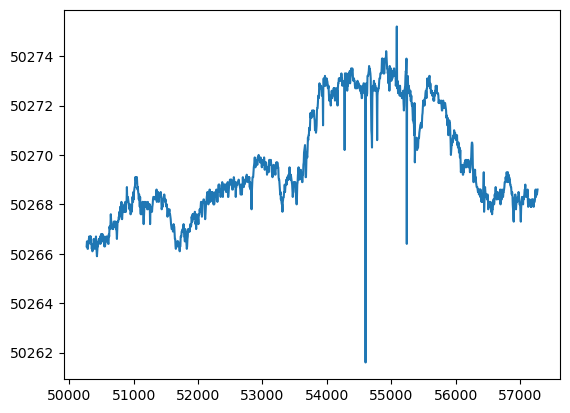

In [5]:
# cutout the first few takenn while we were setting up the base
n_cutoff = 36
plt.plot(base_reading_time[n_cutoff:], base_reading[n_cutoff:])

In [6]:
new_base_frame = pd.DataFrame({
    'MST (Seconds)': base_reading_time,
    'Reading (nT)' : base_reading,
})
new_base_frame['Date (MM/DD/YY)'] = '11/20/25'

new_base_frame

,MST (Seconds),Reading (nT),Date (MM/DD/YY)
0,50037.0,47270.5,11/20/25
1,50077.0,49106.8,11/20/25
2,50100.0,49427.0,11/20/25
3,50105.0,49254.2,11/20/25
4,50110.0,49598.8,11/20/25
...,...,...,...
1432,57250.0,50268.4,11/20/25
1433,57255.0,50268.5,11/20/25
1434,57260.0,50268.4,11/20/25
1435,57265.0,50268.5,11/20/25


In [7]:
new_base_frame.to_csv('base.csv', index=False)

# Reading the rover's data
Next we want to read in the data from the rover, lines containing data look like:

> ```
> 0   49482.685  49444.296 10:00:20.700 01/21/00   0
> 0   49481.455  49452.512 10:00:19.700 01/21/00   0
> 0   49469.042  49445.218 10:00:18.700 01/21/00   0
> 0   49441.940  49441.716 10:00:17.700 01/21/00   0
> 0   49432.124  49437.614 10:00:16.700 01/21/00   0
> 0   49436.095  49436.383 10:00:15.700 01/21/00   0
> 0   49410.932  49474.597 10:00:14.700 01/21/00   0
> 0   49384.295  49497.437 10:00:13.700 01/21/00   0
> 0   49470.942  49477.253 10:00:12.700 01/21/00   0
> ```

Which is again a fixed width format, however there are other lines every once and a while in the file:

> ```
> 0   50393.838  50379.330 15:30:17.20 11/19/24   0
> 0   50395.478  50376.614 15:30:17.10 11/19/24   0
> 0   50396.718  50371.366 15:30:17.00 11/19/24   0
> 6          0.00         0.00 15:30:17.00 11/19/24         58           3          42   4         40
> 0   50397.715  50359.374 15:30:16.90 11/19/24   0
> 0   50398.068  50340.153 15:30:16.80 11/19/24   0
> ```

or 

> ```
> 0   50387.555  50394.655 15:31:19.40 11/19/24   0
> 0   50387.963  50393.767 15:31:19.30 11/19/24   0
> 0   50388.133  50393.485 15:31:19.20 11/19/24   0
> 3          0.00         0.00 15:31:19.10 11/19/24        151           3          47   4
> 0   50387.965  50393.899 15:31:19.10 11/19/24   0
> 0   50387.338  50394.976 15:31:19.00 11/19/24   0
> 0   50386.985  50398.139 15:31:18.90 11/19/24   0
> ```


The first number in the line indicates the type of reading it is, in this case the `0` at the front means it was a magnetics data reading, in which case it is:

```Reading Type   Reading 1(nT)  Reading 2(nT)    Reading time (HH:MM:SS) Reading Date (MM/DD/YY) Flag```

* You should notice right away that it thinks our surveys were down on `01/21/00`... meaning the date on the instrument was wrong...
* We'll have to correct for it using the GPS time

Lines that start with `21` are GPS measurements

> ```
> 21 $GPGGA,220041.00,3945.0614239,N,10513.3039246,W,4,26,0.6,1762.408,M,-15.952,M,3.0,0000*47 10:00:21.100 01/21/00 340 0
21 $GPGGA,220040.00,3945.0614357,N,10513.3039131,W,4,25,0.7,1762.411,M,-15.952,M,2.0,0000*47 10:00:20.100 01/21/00  55 0
>21 $GPGGA,220039.00,3945.0614587,N,10513.3039097,W,4,25,0.7,1762.407,M,-15.952,M,1.0,0000*4B 10:00:19.100 01/21/00   3 0
21 $GPGGA,220038.00,3945.0614524,N,10513.3039021,W,4,25,0.7,1762.413,M,-15.952,M,4.0,0000*4E 10:00:18.100 01/21/00  54 0
>21 $GPGGA,220037.00,3945.0614431,N,10513.3039007,W,4,25,0.7,1762.406,M,-15.952,M,3.0,0000*43 10:00:17.100 01/21/00  19 0
21 $GPGGA,220036.00,3945.0614318,N,10513.3039015,W,4,26,0.6,1762.398,M,-15.952,M,2.0,0000*4E 10:00:16.100 01/21/00 360 0
>21 $GPGGA,220035.00,3945.0614297,N,10513.3039051,W,4,25,0.7,1762.402,M,-15.952,M,1.0,0000*4E 10:00:15.100 01/21/00  32 0
21 $GPGGA,220034.00,3945.0614336,N,10513.3039074,W,4,25,0.7,1762.400,M,-15.952,M,2.0,0000*43 10:00:14.100 01/21/00  61 0
>21 $GPGGA,220033.00,3945.0614221,N,10513.3039036,W,4,25,0.7,1762.400,M,-15.952,M,3.0,0000*44 10:00:13.100 01/21/00  34 0
> ```

These are formatted according to a GPGGA spec, with the timestamp from the machinne appended (see [here](https://docs.novatel.com/OEM7/Content/Logs/GPGGA.htm) for details on the GPGGA message)

First Let's correct the machine time to be the true date time, as we will need it to do a base station correction...

In [231]:
#g858_file = data_folder / 'g858_1.stn'
g858_file = data_folder / 'g858_4.stn'

In [232]:
with open(g858_file, 'r') as file:
    # lets switch all "," to " " to be consistent
    mag_gps_lines = [line.replace(",", " ") for line in file if line.startswith('21')]
virt_mag_gps_file = io.StringIO("".join(mag_gps_lines))

# then pass this virtual file to pandas to parse

mag_gps_frame = pd.read_csv(virt_mag_gps_file, header=None, sep=r'\s+')
mag_gps_frame = mag_gps_frame.rename(
    columns={
        0: 'record type',
        1: 'Log Header',
        2: 'UTC Time (HHMMSS.SS)',
        3: 'Lat (DDMM.MM)',
        4: 'Lat Dir',
        5: 'Lon (DDMM.MM)',
        6: 'Lon Dir',
        7: 'quiality',
        8: '# Satellites',
        9: "HDOP",
        10: "Altitude",
        11: "Alt Units",
        12: "Delta WGS84 Ellipsoid",
        13: "Delta Units",
        14: "Correction Age (S)",
        15: "STN ID and Checksum",
        16: "Machine Time (HH:MM:SS.SSS)",
        17: "Machine Date (DD/MM/YY)",
        19: "Extra info",
        20: "0?",
    }
)

In [233]:
mag_gps_frame

,record type,Log Header,UTC Time (HHMMSS.SS),Lat (DDMM.MM),Lat Dir,Lon (DDMM.MM),Lon Dir,quiality,# Satellites,HDOP,Altitude,Alt Units,Delta WGS84 Ellipsoid,Delta Units,Correction Age (S),STN ID and Checksum,Machine Time (HH:MM:SS.SSS),Machine Date (DD/MM/YY),18,Extra info
0,21,$GPGGA,222324.0,3945.072172,N,10513.316926,W,4,27,0.6,1760.277,M,-15.952,M,2.0,0000*46,10:23:04.100,01/21/00,284,0
1,21,$GPGGA,222323.0,3945.071836,N,10513.316668,W,4,28,0.5,1760.301,M,-15.952,M,3.0,0000*42,10:23:03.100,01/21/00,256,0
2,21,$GPGGA,222322.0,3945.071421,N,10513.316286,W,4,25,0.7,1760.317,M,-15.952,M,2.0,0000*43,10:23:02.100,01/21/00,265,0
3,21,$GPGGA,222321.0,3945.070929,N,10513.315822,W,4,28,0.6,1760.393,M,-15.952,M,3.0,0000*43,10:23:01.100,01/21/00,234,0
4,21,$GPGGA,222320.0,3945.070427,N,10513.315402,W,4,28,0.6,1760.420,M,-15.952,M,2.0,0000*46,10:23:00.100,01/21/00,260,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,21,$GPGGA,221937.0,3945.081939,N,10513.300953,W,4,23,0.7,1759.625,M,-15.953,M,3.0,0000*42,10:19:17.100,01/21/00,282,0
228,21,$GPGGA,221936.0,3945.081917,N,10513.300929,W,4,24,0.6,1759.625,M,-15.953,M,2.0,0000*42,10:19:16.100,01/21/00,244,0
229,21,$GPGGA,221935.0,3945.081932,N,10513.300959,W,4,24,0.7,1759.618,M,-15.953,M,3.0,0000*41,10:19:15.100,01/21/00,276,0
230,21,$GPGGA,221934.0,3945.081939,N,10513.300965,W,4,27,0.6,1759.598,M,-15.953,M,2.0,0000*4D,10:19:14.100,01/21/00,257,0


In [234]:
# Let's get the times in seconds for both the GPS and Machine.
gps_times = np.asarray(mag_gps_frame['UTC Time (HHMMSS.SS)'])
gps_hours = gps_times // 10000
gps_minutes = gps_times // 100 - gps_hours * 100
gps_times = gps_times % 100 + gps_minutes * minute + (gps_hours - 7) * hour  # -7 for UTC to MST

mag_gps_frame['MST Time (S)'] = gps_times

mach_times = []
for time in mag_gps_frame['Machine Time (HH:MM:SS.SSS)']:
    time = time.split(":")
    mac_hour = float(time[0])
    mac_minute = float(time[1])
    mac_second = float(time[2])
    mach_times.append(mac_hour * hour + mac_minute * minute + mac_second)
mach_times = np.asarray(mach_times)

In [235]:
mach_times, gps_times

(array([37384.1, 37383.1, 37382.1, 37381.1, 37380.1, 37379.1, 37378.1,
        37377.1, 37376.1, 37375.1, 37374.1, 37373.1, 37372.1, 37371.1,
        37370.1, 37369.1, 37368.1, 37367.1, 37366.1, 37365.1, 37364.1,
        37363.1, 37362.1, 37361.1, 37360.1, 37359.1, 37358.1, 37357.1,
        37356.1, 37355.1, 37354.1, 37353.1, 37352.1, 37351.1, 37350.1,
        37349.1, 37348.1, 37347.1, 37346.1, 37345.1, 37344.1, 37343.1,
        37342.1, 37341.1, 37340.1, 37339.1, 37338.1, 37337.1, 37336.1,
        37335.1, 37334.1, 37333.1, 37332.1, 37331.1, 37330.1, 37329.1,
        37328.1, 37327.1, 37326.1, 37325.1, 37324.1, 37323.1, 37322.1,
        37321.1, 37320.1, 37319.1, 37318.1, 37317.1, 37316.1, 37315.1,
        37314.1, 37313.1, 37312.1, 37311.1, 37310.1, 37309.1, 37308.1,
        37307.1, 37306.1, 37305.1, 37304.1, 37303.1, 37302.1, 37301.1,
        37300.1, 37299.1, 37298.1, 37297.1, 37296.1, 37295.1, 37294.1,
        37293.1, 37292.1, 37291.1, 37290.1, 37289.1, 37288.1, 37287.1,
      

What is the offset between machine time and gps time?

In [236]:
gps_times - mach_times

array([18019.9, 18019.9, 18019.9, 18019.9, 18019.9, 18019.9, 18019.9,
       18019.9, 18019.9, 18019.9, 18019.9, 18019.9, 18019.9, 18019.9,
       18019.9, 18019.9, 18019.9, 18019.9, 18019.9, 18019.9, 18019.9,
       18019.9, 18019.9, 18019.9, 18019.9, 18019.9, 18019.9, 18019.9,
       18019.9, 18019.9, 18019.9, 18019.9, 18019.9, 18019.9, 18019.9,
       18019.9, 18019.9, 18019.9, 18019.9, 18019.9, 18019.9, 18019.9,
       18019.9, 18019.9, 18019.9, 18019.9, 18019.9, 18019.9, 18019.9,
       18019.9, 18019.9, 18019.9, 18019.9, 18019.9, 18019.9, 18019.9,
       18019.9, 18019.9, 18019.9, 18019.9, 18019.9, 18019.9, 18019.9,
       18019.9, 18019.9, 18019.9, 18019.9, 18019.9, 18019.9, 18019.9,
       18019.9, 18019.9, 18019.9, 18019.9, 18019.9, 18019.9, 18019.9,
       18019.9, 18019.9, 18019.9, 18019.9, 18019.9, 18019.9, 18019.9,
       18019.9, 18019.9, 18019.9, 18019.9, 18019.9, 18019.9, 18019.9,
       18019.9, 18019.9, 18019.9, 18019.9, 18019.9, 18019.9, 18019.9,
       18019.9, 1801

That's good they're all the same and consistent... so let's fix them all! 

In [237]:
machine_time_offset = gps_times[0] - mach_times[0]
machine_time_offset

np.float64(18019.9)

Let's also convert the DDMM.MM formats of Lat and Lon to degrees (with the appropriate sign)

In [238]:
lat = mag_gps_frame['Lat (DDMM.MM)']
lon = mag_gps_frame['Lon (DDMM.MM)']

lat_deg = []
lon_deg = []

def converter(x):
    degrees = x // 100
    minutes = x % 100
    return degrees + minutes / 60

for (lat, lon) in zip(mag_gps_frame['Lat (DDMM.MM)'], mag_gps_frame['Lon (DDMM.MM)']):
    lat_deg.append(converter(lat)) # Positive for N
    lon_deg.append(-converter(lon)) # Negative for W

mag_gps_frame['Lat (Deg N)'] = lat_deg
mag_gps_frame['Lon (Deg E)'] = lon_deg

## The Mag Data

In [239]:
# Let's start by reading only the rows that contained a `0` at the start
# we're going to do a little python trick to create a "virtual" file that
# only returns lines from the data file that start with 0

with open(g858_file, 'r') as file:
    mag_lines = [line for line in file if line.startswith('0')]
virt_mag_file = io.StringIO("".join(mag_lines))

# then pass this virtual file to pandas to parse

mag_frame = pd.read_csv(virt_mag_file, header=None, sep=r'\s+')
mag_frame = mag_frame.rename(
    columns={
        0:'record type',
        1:'top sensor (nT)',
        2:'bottom sensor (nT)',
        3:'reading time (HH:MM:SS.SS)',
        4:'reading date (MM/DD/YY)',
    }
)

# fix the reading date:
mag_frame['reading date (MM/DD/YY)'] = '11/20/25'

In [240]:
mag_frame

,record type,top sensor (nT),bottom sensor (nT),reading time (HH:MM:SS.SS),reading date (MM/DD/YY),5
0,0,0.000,50258.299,10:23:04.400,11/20/25,0
1,0,0.000,50257.032,10:23:03.400,11/20/25,0
2,0,0.000,50257.558,10:23:02.400,11/20/25,0
3,0,0.000,50262.331,10:23:01.400,11/20/25,0
4,0,0.000,50262.494,10:23:00.400,11/20/25,0
...,...,...,...,...,...,...
227,0,50213.853,50208.095,10:19:17.400,11/20/25,0
228,0,50213.287,50207.590,10:19:16.400,11/20/25,0
229,0,50212.651,50206.845,10:19:15.400,11/20/25,0
230,0,50211.875,50206.297,10:19:14.400,11/20/25,0


In [241]:
mag_frame['reading time (HH:MM:SS.SS)']

0      10:23:04.400
1      10:23:03.400
2      10:23:02.400
3      10:23:01.400
4      10:23:00.400
           ...     
227    10:19:17.400
228    10:19:16.400
229    10:19:15.400
230    10:19:14.400
231    10:19:13.400
Name: reading time (HH:MM:SS.SS), Length: 232, dtype: object

In [242]:
# Convert the times to seconds (and fix the offset)
mag_frame['reading time MST (s)'] = pd.to_timedelta(
    mag_frame['reading time (HH:MM:SS.SS)']
).apply(pd.Timedelta.total_seconds) + machine_time_offset 

In [243]:
mag_frame['reading time MST (s)']

0      55404.3
1      55403.3
2      55402.3
3      55401.3
4      55400.3
        ...   
227    55177.3
228    55176.3
229    55175.3
230    55174.3
231    55173.3
Name: reading time MST (s), Length: 232, dtype: float64

(49250.0, 50500.0)

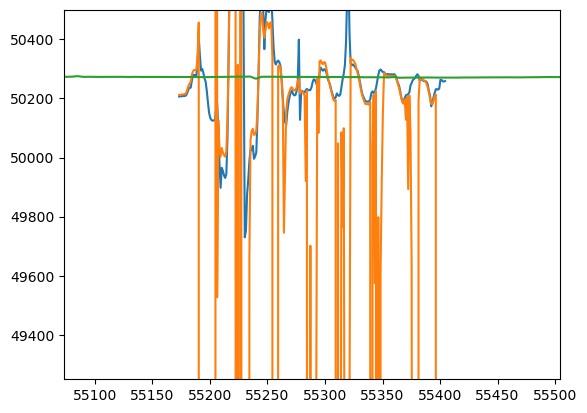

In [244]:
plt.plot(mag_frame['reading time MST (s)'], mag_frame['bottom sensor (nT)'])
plt.plot(mag_frame['reading time MST (s)'], mag_frame['top sensor (nT)'])
plt.plot(base_reading_time[4:], base_reading[4:])
plt.xlim([mag_frame['reading time MST (s)'].min()-100, mag_frame['reading time MST (s)'].max()+100])
plt.ylim([49250,50500])

In [245]:
# Interpolate GPS positions
latitudes = np.interp(mag_frame['reading time MST (s)'], mag_gps_frame["MST Time (S)"][::-1], mag_gps_frame['Lat (Deg N)'][::-1])
longitudes = np.interp(mag_frame['reading time MST (s)'], mag_gps_frame["MST Time (S)"][::-1], mag_gps_frame['Lon (Deg E)'][::-1])

In [246]:
mag_frame['Lat (Deg N)'] = latitudes
mag_frame['Lon (Deg E)'] = longitudes

## Let's output a simpler file to work with

In [247]:
new_frame = pd.DataFrame({
    "Lat (Deg N)": latitudes,
    "Lon (Deg E)": longitudes,
    "MST (Seconds)": mag_frame['reading time MST (s)'],
    "Date (MM/DD/YY)": mag_frame['reading date (MM/DD/YY)'],
    "Top Sensor (nT)": mag_frame['top sensor (nT)'],
    "Bottom Sensor (nT)": mag_frame['bottom sensor (nT)'],
})

In [248]:
new_frame.to_csv('g858_4.csv', index=False, float_format="%.17g")

# Marker lines
Lines in `rover.stn` that do not start with 0 are anything beside magnetics data that are recorded, let's look at them.

You could use these markers to set locations, but we also have the gps locations which we will use, but the general steps when you only have markers are outlined below

In [47]:
with open(g858_file, 'r') as file:
    info_lines = [line[:-1] for line in file if not line.startswith('0') and not line.startswith('21')]
info_lines

['3         0.000        0.000 10:07:43.700 01/21/00          1           0          38   5',
 '3         0.000        0.000 10:07:42.400 01/21/00         13           0          37   4',
 '3         0.000        0.000 10:07:29.700 01/21/00          8           0          36   4',
 '3         0.000        0.000 10:07:22.100 01/21/00         12           0          35   4',
 '3         0.000        0.000 10:07:09.800 01/21/00          6           0          34   4',
 '3         0.000        0.000 10:07:04.00 01/21/00         13           0          33   4',
 '3         0.000        0.000 10:06:51.00 01/21/00          7           0          32   4',
 '3         0.000        0.000 10:06:44.300 01/21/00         12           0          31   4',
 '3         0.000        0.000 10:06:31.700 01/21/00          7           0          30   4',
 '3         0.000        0.000 10:06:25.100 01/21/00         12           0          29   4',
 '3         0.000        0.000 10:06:12.400 01/21/00          

Let's look closer at these lines

They look like:

> ```
> 3          0.00         0.00 15:31:19.10 11/19/24        151           3          47   4
> 3          0.00         0.00 15:31:04.00 11/19/24        145           3          46   4
> ...
> 6          0.00         0.00 14:36:15.00 11/19/24       3269           0           1   5          0
> ```

and so on, Here there's a few bits of information in this marker line:
From left to right:
* The reading type marker:
  * 3 is a position event (Marks or End lines)
  * 6 is a discontinuity event (usually the start of a line, but can also be marks).
* Two floats representing the station x and y location (if these were configured in the instrument)
* The time in HH:MM:SS.SS format
* The date in MM/DD/YY format
* The number of readings since the last marker
* The line number
* The marker number along that line
* (For reading type 6) The number of position (type 3) events since the last discontinuity
* Extra information for the magnetometer

You will need to look through your field notes, and decide which events correspond to which locations. At which point you will then assign a location to each of these locations.

Lets look at all of the marks on line 3 (Your UXO grid)

In [72]:
uxo_marks = [line for line in info_lines if line.split()[6] == '3']
uxo_marks

[]

Your grid was setup like:

```
left_flag --- middle_flag --- right_flag
left_flag --- middle_flag --- right_flag
left_flag --- middle_flag --- right_flag
left_flag --- middle_flag --- right_flag
```

looking at the number of readings between each mark, it's fairly clear which times correspond to which marks. It follows a pattern of... Big Number, Big Number, small number. Each of these corresponds to one of the lines in your grid.

So if I was to connect the marker number in this file to locations in your grid I would probably put them as:

```
0  ---> 1  ---> 2
5  <--- 4  <--- 3
6  ---> 7  ---> 8
11 <--- 10 <--- 9
12 ---> 13 ---> 14
17 <--- 16 <--- 15
18 ---> 19 ---> 20
23 <--- 22 <--- 21
```
and so on, with the line ended after the last flag (mark `48` is after the last flag).

In [12]:
# lets associate each mark with a location:

# setup the X and Y locations of our local grid
# Say X is the direction between Gugg and GC
# Say Y is the distance from CoorsTek
uxo_xs = np.linspace(0, 50, 3)
uxo_ys = np.linspace(0, 15, 16)[::-1]

uxo_grid = np.stack(np.meshgrid(uxo_xs, uxo_ys, indexing='xy'), axis=-1)

print(uxo_grid.shape)

# we need to reverse every other line:
for i in range(uxo_grid.shape[0]):
    if i%2 == 1:
        uxo_grid[i] = uxo_grid[i, ::-1]

# and reshape it into a 2D array, (which we can then use the marker number as an index to determine location)
uxo_grid = uxo_grid.reshape(-1, 2)
# for example, let's look for marker number 10
uxo_grid[10]

(16, 3, 2)


array([25., 12.])

In [13]:
# get the time and marker number from the uxo_marks lines
uxo_marker_times = []
uxo_marker_number = []
# skip the first line to ignore the last mark in the file
for line in uxo_marks[1:]:
    split = line.split()
    time_str = split[3]
    # compute time in seconds:
    H, M, S = time_str.split(":")
    time_sec = int(H) * hour + int(M) * minute + float(S)
    uxo_marker_times.append(time_sec)
    # store marker number
    uxo_marker_number.append(int(split[7]))

In [14]:
# lets get all of the data associated with the uxo data by selecting them based on times

uxo_time_range = (
    (mag_frame['reading time (s)'] >= min(uxo_marker_times)) &
    (mag_frame['reading time (s)'] <= max(uxo_marker_times))
)

uxo_mag_data = mag_frame.drop(mag_frame[~uxo_time_range].index)
uxo_mag_data

,record type,top sensor (nT),bottom sensor (nT),reading time (HH:MM:SS.SS),reading date (MM/DD/YY),5,reading time (s)
32,0,50387.965,50393.899,15:31:19.10,11/19/24,0,55879.1
33,0,50387.338,50394.976,15:31:19.00,11/19/24,0,55879.0
34,0,50386.985,50398.139,15:31:18.90,11/19/24,0,55878.9
35,0,50386.760,50403.246,15:31:18.80,11/19/24,0,55878.8
36,0,50386.411,50408.727,15:31:18.70,11/19/24,0,55878.7
...,...,...,...,...,...,...,...
5421,0,50444.201,50451.589,15:22:20.20,11/19/24,0,55340.2
5422,0,50443.815,50451.571,15:22:20.10,11/19/24,0,55340.1
5423,0,50443.299,50451.602,15:22:20.00,11/19/24,0,55340.0
5424,0,50443.032,50451.891,15:22:19.90,11/19/24,0,55339.9


In [15]:
def associate_data_position(marker_times, marker_positions, reading_times):
    """
    Parameters
    ----------
    marker_times : (n_mark,) numpy.ndarray
        The times associated with the markers
    marker_positions : (n_mark, 2) numpy.ndarray
        The x and y location associated with each marker.
    reading_times : (n_readings, ) numpy.ndarray
        The times associated with the readings.
    """
    marker_times = np.asarray(marker_times)
    marker_positions = np.asarray(marker_positions)
    arg_sort = np.argsort(marker_times)

    marker_times = marker_times[arg_sort]
    marker_positions = marker_positions[arg_sort]
    
    x_interp = np.interp(reading_times, marker_times, marker_positions[:, 0], left=np.nan, right=np.nan)
    y_interp = np.interp(reading_times, marker_times, marker_positions[:, 1], left=np.nan, right=np.nan)
    return np.stack((x_interp, y_interp), axis=-1)

In [16]:
# get locations for each marker:
uxo_marker_locs = uxo_grid[uxo_marker_number]

# then assign positions to each data point using the function!
data_locs = associate_data_position(uxo_marker_times, uxo_marker_locs, uxo_mag_data['reading time (s)'])
data_locs

array([[ 0.        ,  0.        ],
       [ 0.16556291,  0.        ],
       [ 0.33112583,  0.        ],
       ...,
       [ 0.625     , 15.        ],
       [ 0.46875   , 15.        ],
       [ 0.3125    , 15.        ]], shape=(5394, 2))

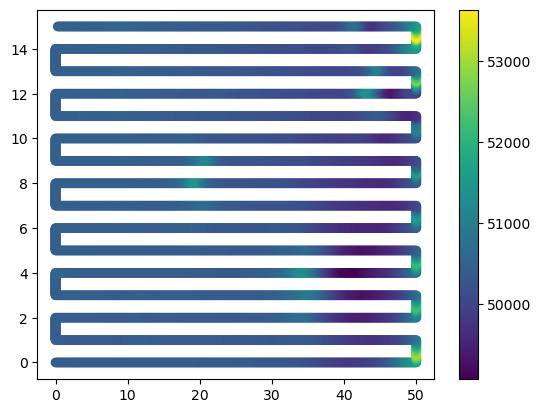

In [17]:
# I'm just doing a quick scatter plot of this data set for viewing purposes, you will still want to:
# 1) Remove the turn around points
# 2) Interpolate the data to make an image.

dat = uxo_mag_data['top sensor (nT)']
plt.scatter(data_locs[:, 0], data_locs[:, 1], c=dat)
plt.colorbar()

At this point, we probably also want to remove the points between lines when the operator was turning around. You can filter out all of those data points on your own.

# Summary
The steps I did to locate the data points:

* Read in the data, split into:
   * Magnetic sensor readings
   * Marked lines
* Associated each marked line with a location in space.
* Linearly interpolated the position between marks in time.

The hardest thing for you will be to associate the marks with locations in space.

**ATTENTION** You still need to apply a drift correction using the base station data